# Monte-Carlo Simulations

Note that Parsl is not effective if multiple CPU cores aren't available because Parsl's ability to execute tasks in parallel is depenedent on the availability multiple cores.

In [1]:
import multiprocessing
print('Cores available: {}'.format(multiprocessing.cpu_count()))

Cores available: 4


We'll be using the htex configuration for Parsl. Read more [here.]( https://github.com/Parsl/parsl/blob/master/parsl/configs/htex_local.py)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import parsl
import os
from parsl.app.app import python_app, bash_app
from parsl.providers import LocalProvider
from parsl.channels import LocalChannel

from parsl.config import Config
from parsl.executors import HighThroughputExecutor

config = Config(
    executors=[
        HighThroughputExecutor(
            label="htex_local",
            cores_per_worker=1,
            provider=LocalProvider(
                channel=LocalChannel(),
                init_blocks=1,
                max_blocks=1,
            ),
        )
    ],
)

parsl.load(config)

Let us work with a simple trading function that estimates the change in a stock if there is a volatility of 0.5% every day.

In [3]:
'''
Building a python app that generates a random percentage between 5 and -5,
and then adjusts the stock price.
'''

@python_app
def stock_price(price):
    import random
    percentage_change = 10*random.random()-5
    
    return price*(100+percentage_change)/100

We run the same python app 100 times and then collect the final stock price. We repeat such a simulation for 1000 times and collect the final prices. Note: this may take a little while to complete, please be patient.

In [4]:
# Evaluating the final prices

final_prices = []

for _ in range(1000): ## A 1000 simulations
    
    original_price = 15
    for i in range(100): 
        '''
        For each simulation, we simulate the stock price over 100 days
        '''
        original_price = stock_price(original_price)
    
    final_prices.append(original_price)

We now evaluate the AppFuture results.

In [5]:
final_prices = [i.result() for i in final_prices]

In [6]:
print('Mean Stock Price: ', np.mean(final_prices))
print('95% Confidence Interval of Stock Price: ', (np.percentile(final_prices,2.5),
                                                   np.percentile(final_prices,97.5)))

Mean Stock Price:  14.954417224126484
95% Confidence Interval of Stock Price:  (8.489963369529612, 25.346680877871822)


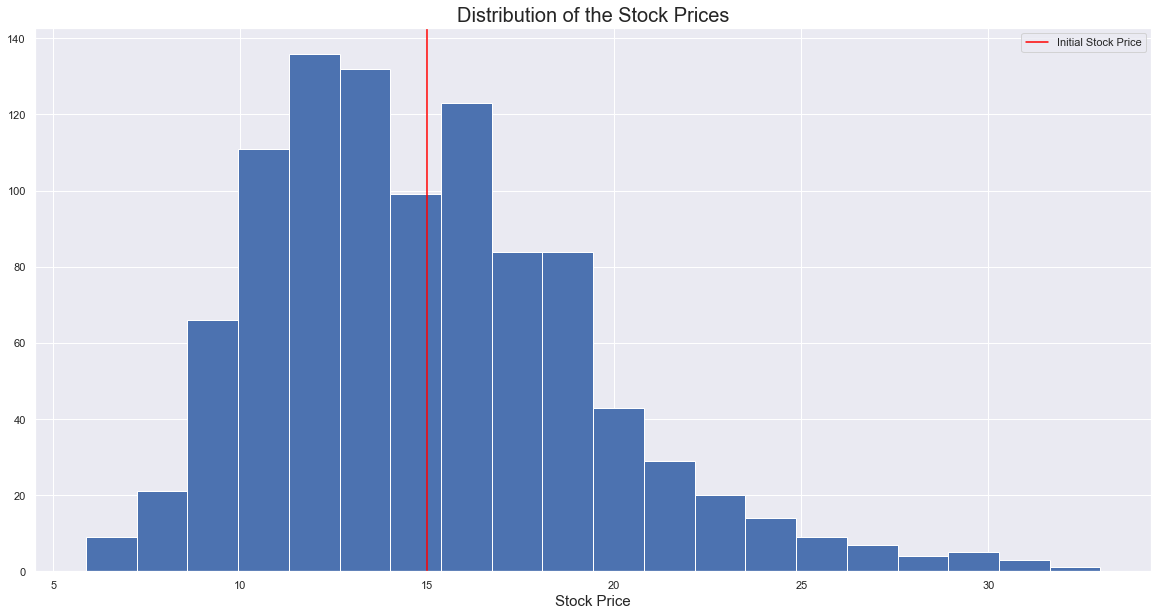

In [7]:
'''
Plotting the historgram of the final stock prices
'''

plt.figure(figsize=(20,10))
plt.hist(final_prices, bins=20)
plt.title('Distribution of the Stock Prices', fontsize=20)
plt.axvline(15, color='red', label='Initial Stock Price')
plt.xlabel('Stock Price', fontsize=15)
plt.legend()
plt.show()